In [113]:
import pandas as pd
import numpy as np

## Define preprocessing function

In [148]:
def import_data():
    # Import data

    col_names = pd.read_csv("communities_names.csv", header = None)
    list_of_column_names = []

    for index, row_data in col_names.iterrows():
        list_of_column_names.append(str(row_data[0]))

    data = pd.read_csv("communities_data.csv", names = list_of_column_names)

    # Remove categorical columns 
    # 1: county and communities have many missing values
    # 2: communityname would be a direct indicator of crime and should be removed
    # 3: state is not that important

    data.drop(labels = ["state", "county", "community", "communityname"],axis = 1, inplace = True)

    # We also remove the fold-column since this is only present for reproducing article findings

    data.drop(labels = ["fold"],axis = 1, inplace = True)

    # Drop columns with missing data
    col_names_missing_vals = pd.read_csv("communities_names_missing.csv", header = None)
    list_of_column_names_missing_vals = []

    for index, row_data in col_names_missing_vals.iterrows():
        list_of_column_names_missing_vals.append(str(row_data[0]))


    data.drop(labels = list_of_column_names_missing_vals,axis = 1, inplace = True)

    null = data.isnull().values.any()
    if null: 
        print("There are missing values in the data")
    
    # Make a full dataframe where we have not removed the protected columns or the label
    data_full = data.copy()
    
    # Make a categorical column for blackness where we set a threshold (just for visualization purposes)
    racepctblack = np.asarray(data.racepctblack)
    threshold = 0.4
    IsBlack = [1 if x>threshold else 0 for x in racepctblack]
    data["IsBlack"] = IsBlack
    
    # Remove protected features and put into separate dataframe
    # Note: this includes all racepct-columns (black, white, asian, hipspanic), since one can be somewhat derived from the others
    protected_cols = ["IsBlack", "racepctblack", "racePctWhite", "racePctAsian", "racePctHisp"]
    data_protected = pd.concat([data.pop(x) for x in protected_cols], axis=1)
    
    # Remove y column (the label)
    y_col = "ViolentCrimesPerPop"
    data_y = data.pop(y_col)
    
    return data_full, data, data_protected, data_y



In [149]:
df_all, df, df_protected, df_y = import_data()

In [151]:
df_all.describe()

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn,ViolentCrimesPerPop
count,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,...,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000
mean,0.057593,0.463395,0.179629,0.753716,0.153681,0.144022,0.424218,0.493867,0.336264,0.423164,...,0.215552,0.608892,0.535050,0.626424,0.651530,0.065231,0.232854,0.161685,0.094052,0.237979
std,0.126906,0.163717,0.253442,0.244039,0.208877,0.232492,0.155196,0.143564,0.166505,0.179185,...,0.231134,0.204329,0.181352,0.200521,0.198221,0.109459,0.203092,0.229055,0.240328,0.232985
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.010000,0.350000,0.020000,0.630000,0.040000,0.010000,0.340000,0.410000,0.250000,0.300000,...,0.060000,0.470000,0.420000,0.520000,0.560000,0.020000,0.100000,0.020000,0.000000,0.070000
50%,0.020000,0.440000,0.060000,0.850000,0.070000,0.040000,0.400000,0.480000,0.290000,0.420000,...,0.130000,0.630000,0.540000,0.670000,0.700000,0.040000,0.170000,0.070000,0.000000,0.150000
75%,0.050000,0.540000,0.230000,0.940000,0.170000,0.160000,0.470000,0.540000,0.360000,0.530000,...,0.280000,0.777500,0.660000,0.770000,0.790000,0.070000,0.280000,0.190000,0.000000,0.330000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Representation bias


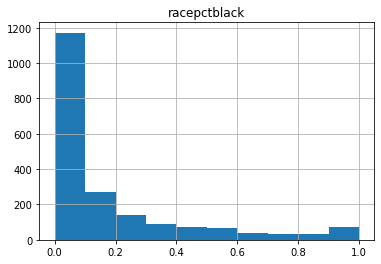

In [124]:
df.hist(column = "racepctblack")

print("Representation bias")

array([[<AxesSubplot:title={'center':'IsBlack'}>]], dtype=object)

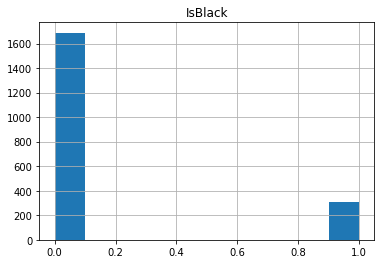

In [123]:
df.hist(column = "IsBlack")

In [126]:
df

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn,ViolentCrimesPerPop,IsBlack
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,...,0.42,0.50,0.51,0.64,0.12,0.26,0.20,0.32,0.20,0
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,0.50,0.34,0.60,0.52,0.02,0.12,0.45,0.00,0.67,0
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,...,0.49,0.54,0.67,0.56,0.01,0.21,0.02,0.00,0.43,1
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,...,0.30,0.73,0.64,0.65,0.02,0.39,0.28,0.00,0.12,1
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,...,0.72,0.64,0.61,0.53,0.04,0.09,0.02,0.00,0.03,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,0.01,0.40,0.10,0.87,0.12,0.16,0.43,0.51,0.35,0.30,...,0.28,0.34,0.48,0.39,0.01,0.28,0.05,0.00,0.09,0
1990,0.05,0.96,0.46,0.28,0.83,0.32,0.69,0.86,0.73,0.14,...,0.25,0.17,0.10,0.00,0.02,0.37,0.20,0.00,0.45,1
1991,0.16,0.37,0.25,0.69,0.04,0.25,0.35,0.50,0.31,0.54,...,0.68,0.61,0.79,0.76,0.08,0.32,0.18,0.91,0.23,0
1992,0.08,0.51,0.06,0.87,0.22,0.10,0.58,0.74,0.63,0.41,...,0.64,0.54,0.59,0.52,0.03,0.38,0.33,0.22,0.19,0
